In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
from pqdict import pqdict
from itertools import cycle
import time
import os
import math
import random
from collections import deque
import pandapower as pp
import pandapower.networks as pn
from config import get_project_root
import sys
    
sys.path.append(os.path.dirname(os.path.abspath('config.py')))
start_time = time.time()

# Define the path to the Excel file
project_root = get_project_root()
distance_matrix_path= os.path.join(project_root,  'Dataset', 'Distance matrix between the nodes_1.xlsx')
customer_data_path= os.path.join(project_root,  'Dataset', 'Customer demand data with time window in KWH_1.xlsx')
excavator_data_path = os.path.join(project_root,  'Dataset', 'Excavator details_1.xlsx')
traffic_data_path = os.path.join(project_root,  'Dataset', 'Traffic Data.xlsx')

# Load the Road Terrain information
terrain_data_path =  os.path.join(project_root, 'Dataset', 'Road Terrain information.xlsx')


In [2]:
# Check if distance_matrix_path is already a DataFrame
if isinstance(distance_matrix_path, pd.DataFrame):
    distance_matrix = distance_matrix_path
else:
    # If it's a string (file path), read the Excel file
    distance_matrix = pd.read_excel(distance_matrix_path, index_col=0)

distance_matrix = distance_matrix.replace(-1, np.inf)

# Similarly for customer_data_path and excavator_data_path
if isinstance(customer_data_path, pd.DataFrame):
    customer_data = customer_data_path
else:
    customer_data = pd.read_excel(customer_data_path, index_col=0)

if isinstance(excavator_data_path, pd.DataFrame):
    excavator_data = excavator_data_path
else:
    excavator_data = pd.read_excel(excavator_data_path, index_col=0)

if isinstance(traffic_data_path, pd.DataFrame):
    traffic_data = traffic_data_path
else:
    traffic_data = pd.read_excel(traffic_data_path)

if isinstance(terrain_data_path, pd.DataFrame):
    terrain_df = terrain_data_path
else:
    terrain_df = pd.read_excel(terrain_data_path)

# Create a gradient matrix
num_nodes = max(terrain_df['Node From'].max(), terrain_df['Node To'].max()) + 1
gradient_matrix = np.zeros((num_nodes, num_nodes))

# Fill the gradient matrix
for _, row in terrain_df.iterrows():
    from_node = row['Node From']
    to_node = row['Node To']
    gradient = row['Gradient (%)']
    gradient_matrix[from_node][to_node] = gradient
    gradient_matrix[to_node][from_node] = -gradient  # Assuming symmetry for the return trip


# Convert customer data to dictionary
customers_data = customer_data.to_dict(orient='records')

#Input data
vehicles = [
    {'id': 1, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 2, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 3, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 4, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 5, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.0, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 6, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 7, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 8, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 9, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 10, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 11, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 12, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 13, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.0, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 14, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 15, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 16, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 17, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 18, 'type': 'Small', 'capacity': 350, 'speed': 50, 'KWh_per_km': 1, 'hourly_wage': 18, 'mass': 50000, 'a_k': 1.2},
    {'id': 19, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 20, 'type': 'Medium', 'capacity': 350, 'speed': 45, 'KWh_per_km': 1, 'hourly_wage': 19, 'mass': 50000, 'a_k': 1.2},
    {'id': 21, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.0, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 22, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 23, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2},
    {'id': 24, 'type': 'Large', 'capacity': 350, 'speed': 40, 'KWh_per_km': 1.5, 'hourly_wage': 20, 'mass': 50000, 'a_k': 1.2}
]

node_types = {
    0: 'Depot',
    1: 'Charging site',
    2: 'Construction site',
    3: 'Charging site',
    4: 'Construction site',
    5: 'Construction site',
    6: 'Construction site'
}

# Define construction sites and charging sites
construction_sites = [2, 4, 5, 6]
charging_sites = [1, 3]

In [3]:
from tabulate import tabulate
def calculate_lmp_prices():
    """
    Calculate LMP prices for buses 6, 10, and 11 over 24 hours.
    Returns a DataFrame with hourly LMP values for each bus.
    """
    # Create the CIGRE 20 kV network
    net = pn.create_cigre_network_mv(with_der=False)
    
    # Generate 24-hour load profile
    hours = np.arange(24)
    baseline_profile = 1 + 0.2 * np.sin((hours - 6) / 24 * 2 * np.pi)
    morning_peak = 0.3 * np.exp(-0.5 * ((hours - 8) / 1.5) ** 2)
    evening_peak = 0.6 * np.exp(-0.5 * ((hours - 19) / 2) ** 2)
    profile = baseline_profile + morning_peak + evening_peak
    profile = profile / np.max(profile) * 1.5 * 0.6  # Scale and reduce by 40%
    
    # Create load profiles for each bus
    load_data = net.load.groupby('bus')[['p_mw', 'q_mvar']].sum().reset_index()
    load_data['s_mva'] = np.sqrt(load_data['p_mw']**2 + load_data['q_mvar']**2)
    load_data['power_factor'] = load_data['p_mw'] / load_data['s_mva']
    
    # Generate load profiles
    load_profiles = []
    for _, row in load_data.iterrows():
        s_profile = row['s_mva'] * profile
        p_profile = s_profile * row['power_factor']
        q_profile = np.sqrt(s_profile**2 - p_profile**2)
        
        load_profile_df = pd.DataFrame({
            'bus': [row['bus']] * 24,
            'hour': hours,
            'p_mw': p_profile,
            'q_mvar': q_profile
        })
        load_profiles.append(load_profile_df)
    
    combined_load_profile = pd.concat(load_profiles, ignore_index=True)
    combined_load_profile = combined_load_profile.groupby(['bus', 'hour'], as_index=False).sum()
    
    # Calculate LMP
    lmp_results = []
    day_ahead_price_profile_cents = np.random.uniform(30, 60, 24) * 0.6
    
    for hour in range(24):
        try:
            # Update network loads and run power flow
            for _, row in combined_load_profile[combined_load_profile['hour'] == hour].iterrows():
                net.load.loc[net.load['bus'] == row['bus'], 'p_mw'] = row['p_mw']
                net.load.loc[net.load['bus'] == row['bus'], 'q_mvar'] = row['q_mvar']
            
            pp.runpp(net, calculate_voltage_angles=True, init='auto', max_iteration=30)
            
            # Calculate sensitivities and LMP components
            J = net._ppc['internal'].get('J', None)
            if J is not None and J.ndim == 2:
                J_reg = J + np.eye(J.shape[0]) * 1e-6
                J_inv = np.linalg.inv(J_reg)
                sensitivity_VP_diagonal = np.diag(J_inv[:len(net.bus), len(net.bus):])
                
                for bus in [6, 10, 11]:
                    alpha_i = sensitivity_VP_diagonal[bus]
                    forecast_deviation = combined_load_profile[
                        (combined_load_profile['bus'] == bus) & 
                        (combined_load_profile['hour'] == hour)
                    ]['p_mw'].values[0] - net.load['p_mw'].mean()
                    
                    # Calculate LMP components
                    lambda_energy_DA = day_ahead_price_profile_cents[hour] * (1 + alpha_i * forecast_deviation)
                    lambda_loss_DA = (1 + 0.1 * alpha_i * 0.5)
                    lambda_tariff = 15 if (6 <= hour < 9 or 17 <= hour < 21) else 8
                    delta_lambda_RT = 0.01 * (net.res_line['pl_mw'].sum()) + 0.02 * 0.5
                    
                    lambda_total = lambda_energy_DA + lambda_loss_DA + lambda_tariff +delta_lambda_RT
                    
                    lmp_results.append({
                        'hour': hour,
                        'bus': int(bus),
                        'lmp': lambda_total
                    })
                
        except Exception as e:
            print(f"Error calculating LMP for hour {hour}: {e}")

    current_results = pd.DataFrame(lmp_results)
    print(tabulate(current_results, headers='keys', tablefmt='grid', showindex=False))
    
    return pd.DataFrame(lmp_results)

In [4]:
def get_charging_cost(charging_site, current_time, lmp_df):
    """
    Get charging cost based on LMP for a specific charging site and time.
    """
    charging_site_to_bus = {
        1: 6,   # Charging site 1 uses Bus 6 LMP
        3: 10,   # Charging site 3 uses Bus 6 LMP
       }
    
    # Get the corresponding bus for this charging site
    bus = charging_site_to_bus[charging_site]
    
    # Convert current_time to the nearest hour (handling times > 24)
    hour = int(current_time) % 24
    
    # Get LMP for this bus and hour
    lmp = lmp_df[(lmp_df['bus'] == bus) & (lmp_df['hour'] == hour)]['lmp'].values[0]
    
    # Convert from cents to dollars
    return lmp / 100.0

In [5]:
# Function to get gradient between two nodes
def get_gradient(from_node, to_node):
    return gradient_matrix[from_node][to_node]

In [6]:
def generate_data(distance_matrix, customer_data, excavator_data):
    
    distance_matrix_numeric = distance_matrix.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], 1e6)
    
    #num_nodes = distance_matrix_numeric.shape[0]
    num_nodes = len(distance_matrix)
    
    #locations = np.zeros((num_nodes, 2))
    # Generate random locations for visualization
    locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_nodes)]
    
    # Initialize SOC columns if they don't exist
    if 'SOC_1' not in excavator_data.columns:
        excavator_data['SOC_1'] = 100
    if 'SOC_2' not in excavator_data.columns:
        excavator_data['SOC_2'] = 100
        
    excavator_data['SOC_1'] = excavator_data['SOC_1'].astype(float)
    excavator_data['SOC_2'] = excavator_data['SOC_2'].astype(float)

 
    # Set the first node at an arbitrary location (e.g., center of a 100x100 grid)
    locations[0] = [50, 50]
    
    # Place other nodes based on distances from the first node
    for i in range(1, num_nodes):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = distance_matrix_numeric.iloc[0, i]
        if distance < 1e6:
            locations[i] = locations[0] + distance * np.array([np.cos(angle), np.sin(angle)])
        else:
            # If distance is very large, place the node randomly
            locations[i] = np.random.uniform(0, 100, 2)
    
        # Define node types
    node_types = {
        0: 'Depot',
        1: 'Charging site',
        2: 'Construction site',
        3: 'Charging site',
        4: 'Construction site',
        5: 'Construction site',
        6: 'Construction site'
    }
    
    nodes = []
    for i in range(num_nodes):
        node_type = node_types.get(i, 'Unknown')  # Use 'Unknown' if node type is not defined
        node_id = distance_matrix.index[i] 
        
        node = {
            'id': node_id,
            'location': locations[i],
            'type': node_type,
        }
        if node_id in customer_data.index:
            node.update({
                'demand_kWh': customer_data.loc[node_id, 'Requirement of KWH'],
                'Return_kWh': customer_data.loc[node_id, 'Present KWH'],
                'soc': customer_data.loc[node_id, 'Present SOC'],
                'time_window': (customer_data.loc[node_id, 'StartTime'], customer_data.loc[node_id, 'EndTime']),
                'mess_size': customer_data.loc[node_id, 'Requirement of KWH'],
            })
        else:
            node.update({
                'demand_kWh': 0,
                'Return_kWh': 0,
                'soc': 100,
                'time_window': (0, 24),
                'mess_size': 0,
            })
        node.update({
            'demand_met': False,
            'replacements': 0,
            'being_serviced': False,
            'service_end_time': None,
        })

        nodes.append(node)
    
    return nodes, distance_matrix_numeric.values

In [7]:
def update_soc_with_excavators(nodes, excavator_data, customer_data, elapsed_time, current_time):
    nodes_needing_replacement = []
    for node in nodes:
        if node['id'] not in construction_sites:
            continue  # Skip non-construction sites

        # print(f"\nUpdating Node {node['id']} at time {current_time:.2f}:")
        # print(f"  Initial MESS SOC: {node['soc']:.2f}%")

        if node.get('being_serviced', False) and current_time < node.get('service_end_time', float('inf')):
            # print(f"  Skipping update: Node is being serviced until {node['service_end_time']:.2f}")
            continue

        if node['id'] not in customer_data.index:
            print(f"  Skipping update: Node {node['id']} not found in customer data")
            continue

        mess_capacity = customer_data.loc[node['id'], 'Present KWH']
        node_excavators = excavator_data.loc[node['id']]
        charging_power = 170

        #total_charging_time = 0
        total_energy_transferred = 0

        for excavator_num in [1, 2]:
            excavator_capacity = node_excavators[f'Capacity of the excavator {excavator_num} (KWh)']
            excavator_consumption = node_excavators[f'Consumption of excavator {excavator_num} (KWh/h)']
            initial_excavator_soc = node_excavators.get(f'SOC_{excavator_num}', 100)  # Default to 100 if not present


            # Calculate excavator battery degradation
            soc_decrease = (excavator_consumption * elapsed_time / excavator_capacity) * 100
            new_excavator_soc = max(0, initial_excavator_soc - soc_decrease)
            excavator_data.at[node['id'], f'SOC_{excavator_num}'] = new_excavator_soc

            #print(f"  Excavator {excavator_num} SOC decreased from {initial_excavator_soc:.2f}% to {new_excavator_soc:.2f}%")

            if new_excavator_soc <= 20:
                energy_needed = (0.9 - new_excavator_soc/100) * excavator_capacity  # Energy needed to charge to 90%
                full_charging_time = energy_needed / charging_power  # Time in hours

                if node['soc'] > 20:  # Only charge if MESS has enough power
                    energy_this_step = min(energy_needed, charging_power * elapsed_time)
                    soc_increase = (energy_this_step / excavator_capacity) * 100
                    charged_excavator_soc = min(90, new_excavator_soc + soc_increase)
                    excavator_data.at[node['id'], f'SOC_{excavator_num}'] = charged_excavator_soc
                    
                    #total_charging_time += charging_time
                    total_energy_transferred += energy_this_step

        # Calculate MESS SOC degradation
        if total_energy_transferred > 0:
            mess_soc_decrease = (total_energy_transferred / mess_capacity) * 100
            node['soc'] = max(0, node['soc'] - mess_soc_decrease)
            # print(f"  MESS SOC decreased by {mess_soc_decrease:.2f}% due to excavator charging")
            # print(f"  Energy transferred this step: {total_energy_transferred:.2f} kWh")
        else:
            # If no charging occurred, apply idle degradation
            idle_degradation = (2 * elapsed_time / mess_capacity) * 100
            node['soc'] = max(0, node['soc'] - idle_degradation)
            # print(f"  MESS SOC decreased by {idle_degradation:.2f}% due to idle degradation")

        # print(f"  Final MESS SOC: {node['soc']:.2f}%")

        if node['soc'] <= 20:
            nodes_needing_replacement.append(node)
            #print("  Flagged for replacement")

    return nodes, excavator_data, nodes_needing_replacement

In [8]:
def get_traffic_intensity(zone_id, current_time, traffic_data):
    time_segment = "Morning Peak" if 7 <= current_time < 12 else "Evening Peak"
    intensity = traffic_data[(traffic_data['Zone ID'] == zone_id) & 
                             (traffic_data['Time Segment'] == time_segment)]['Traffic Intensity Index'].values[0]
    return intensity

In [9]:
def calculate_travel_time(distance, vehicle_speed, current_time, traffic_data):
    # first 2 KM in Zone 1
    zone1_distance = min(2, distance)
    remaining_distance = max(0, distance - 2)
    
    # Split remaining distance equally between Zone 2 and 3
    zone2_distance = zone3_distance = remaining_distance / 2
    
    zone1_intensity = get_traffic_intensity(1, current_time, traffic_data)
    zone2_intensity = get_traffic_intensity(2, current_time, traffic_data)
    zone3_intensity = get_traffic_intensity(3, current_time, traffic_data)
    
    time_zone1 = zone1_distance / (vehicle_speed * zone1_intensity)
    time_zone2 = zone2_distance / (vehicle_speed * zone2_intensity)
    time_zone3 = zone3_distance / (vehicle_speed * zone3_intensity)
    
    total_time = time_zone1 + time_zone2 + time_zone3
    return total_time

In [10]:
def calculate_gradient_soc_change(distance, gradient, vehicle):
    # Constants
    g = 9.8  # acceleration due to gravity (m/s^2)
    # Convert gradient from percentage to radians
    theta =(gradient/ 100)
    #print(f"  DEBUG: Theta value: {theta}")
    s = np.sin(theta)
       
    # Calculate required force to overcome the gradient
    F_r = vehicle['mass'] * g * s
    
    
    # Convert vehicle speed from km/h to m/s
    speed_ms = vehicle['speed'] * 1000 / 3600
    #print(f"  DEBUG: Speed: {speed_ms}")
    # Calculate required power (in kW)
    P = (F_r * speed_ms)/1000
    #print(f"  DEBUG: power in KW: {P}")
    
    # Calculate energy consumed per kilometer (kWh/km)
    E_k = P / (vehicle['speed'])
    #print(f"  DEBUG: Energy consume per KM: {E_k}")
    # Calculate total energy consumption for the given distance
    EN = vehicle['a_k'] + E_k * distance + np.random.normal(0, 0.01)  # Adding small random error

    #print(f"  DEBUG: Energy consumption for the given distance: {EN}")
    
    # Calculate SOC change
    soc_change = (EN / vehicle['capacity']) * 100

    #print(f"  DEBUG: SOC change: {soc_change}")
    
    return soc_change

In [11]:
def calculate_battery_degradation_cost(initial_soc, final_soc, C_cap, beta_0, beta_1, beta_2):
    initial_soc= 85
    if initial_soc <= final_soc or initial_soc > 100 or final_soc < 0:
        return 0  # No degradation cost if SOC increases or invalid SOC values

    initial_dod = 1 - (initial_soc / 100)
    final_dod = 1 - (final_soc / 100)

    def N_cycle(initial_dod, final_dod):
        
        N_cy_initial_DOD = beta_0 * (initial_dod ** -beta_1) * math.exp(beta_2 * (1 - initial_dod))
        N_cy_final_DOD = beta_0 * (final_dod ** -beta_1) * math.exp(beta_2 * (1 - final_dod))
        return N_cy_initial_DOD, N_cy_final_DOD 

    def CE(N_cy_initial_DOD,  N_cy_final_DOD):
        return (C_cap / N_cy_initial_DOD), (C_cap / N_cy_final_DOD)

    # Calculate degradation cost only if initial SOC is 85% or less
    N_cy_initial_DOD, N_cy_final_DOD = N_cycle(initial_dod, final_dod)
    CE_initial, CE_final = CE(N_cy_initial_DOD,  N_cy_final_DOD)
                              
    degradation_cost = CE_final-CE_initial

    return degradation_cost

In [12]:
def prepare_nodes_for_replacement(nodes_needing_replacement):
    return [node['id'] for node in nodes_needing_replacement if node['id'] in construction_sites]

In [13]:
def assign_vehicles_to_nodes(node_ids, vehicles, nodes, used_vehicles):
    available_vehicles = [v for v in vehicles if v['id'] not in used_vehicles]
    if not available_vehicles:
        available_vehicles = vehicles
        used_vehicles.clear()
    
    vehicle_queue = deque(sorted(available_vehicles, key=lambda v: v['capacity']))
    vehicle_assignments = {v['id']: [] for v in vehicles}
    vehicle_capacities = {v['id']: v['capacity'] for v in vehicles}
    unassigned_nodes = []

    sorted_nodes = sorted(node_ids, key=lambda x: next(node['soc'] for node in nodes if node['id'] == x))

    for node_id in sorted_nodes:
        node = next(node for node in nodes if node['id'] == node_id)
        assigned = False

        for _ in range(len(vehicle_queue)):
            vehicle = vehicle_queue.popleft()
            if node['mess_size'] <= vehicle_capacities[vehicle['id']]:
                vehicle_assignments[vehicle['id']].append(node_id)
                vehicle_capacities[vehicle['id']] -= node['mess_size']
                assigned = True
                used_vehicles.add(vehicle['id'])
                vehicle_queue.append(vehicle)
                break
            else:
                vehicle_queue.append(vehicle)

        if not assigned:
            unassigned_nodes.append(node_id)

    return vehicle_assignments

In [14]:
def calculate_route_cost(total_distance, arrival_time, vehicle):
    road_toll_per_km = .20  # Average toll for all routes
    Vehicle_maintenance_cost_per_KM= 0.21
    electricity_cost_per_kwh = 0.20

    # Calculate electricity cost for the total distance
    electricity_cost = total_distance * vehicle['KWh_per_km'] * electricity_cost_per_kwh

    road_toll= total_distance * road_toll_per_km

    # Calculate manpower cost based on total operational time
    manpower_cost = arrival_time * vehicle['hourly_wage']

    #calculate Maintenance cost
    Vehicle_maintenance_cost= total_distance * Vehicle_maintenance_cost_per_KM

    return electricity_cost + manpower_cost + road_toll+ Vehicle_maintenance_cost

In [15]:
def calculate_true_route_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i+1]]
    return total_distance

In [16]:
def nearest_neighbor_route(nodes, assigned_nodes, vehicle, current_time, depot_location, distance_matrix, excavator_data, customer_data, traffic_data, lmp_df):
    depot_location = int(depot_location) if isinstance(depot_location, np.ndarray) else depot_location
    cost_optimized_route = [depot_location]
    distance_minimized_route = [depot_location]
    total_cost_optimized_distance = 0
    total_distance_minimized_distance = 0
    total_cost_optimized_cost = 0
    total_distance_minimized_cost = 0
    total_cost_optimized_degradation = 0
    total_distance_minimized_degradation = 0
    visited_cost = set([depot_location])
    visited_distance = set([depot_location])
    skipped_nodes = set()
    service_time = 0.5  # 0.5 hours per node
    total_charging_cost = 0
    total_charging_time = 0
    total_delivery_kWh = 0
    old_mess_return_soc = {}
    after_service_soc = {}
    new_mess_arrival_soc = {}
    current_soc_cost = 90.0
    current_soc_distance = 90.0
    current_time_cost = current_time
    current_time_distance = current_time
    CHARGING_POWER = 500  # 500 kW charging point
    

    # Battery degradation parameters
    C_cap = 60000
    beta_0 = 4901
    beta_1 = 1.98
    beta_2 = 0.016

    #print(f"Starting route from depot at location {depot_location} at time {current_time:.2f}")

    def find_best_route(start, end, current_time, current_soc, distance_matrix, lmp_df, force_charging=False):
        # Direct path
        if not force_charging:
            direct_distance = distance_matrix[start][end]
            direct_gradient = get_gradient(start, end)
            direct_travel_time = calculate_travel_time(direct_distance, vehicle['speed'], current_time, traffic_data)
            direct_final_soc = calculate_final_soc(current_soc, direct_distance, vehicle, direct_gradient) 
            direct_operational_cost = calculate_route_cost(direct_distance, direct_travel_time, vehicle)
            direct_degradation_cost = max (0, calculate_degradation(current_soc, direct_final_soc))
            direct_total_cost = direct_operational_cost + direct_degradation_cost            
            
            #print(f"  Direct path total cost: {direct_total_cost}")
            # print(f" SOC% after reaching node via direct route: {direct_final_soc}")
            
            best_route = [start, end]
            best_distance = direct_distance
            best_travel_time = direct_travel_time
            best_cost = direct_total_cost
            best_final_soc = direct_final_soc
            best_charging_time = 0
            best_charging_cost = 0
            best_energy_charged = 0
        else:
            best_cost = float('inf')
            best_charging_time = 0
            best_charging_cost = 0
            best_energy_charged = 0

        # Indirect paths via charging sites
        best_indirect_cost = float('inf')
        best_indirect_route = None
        best_indirect_distance = 0
        best_indirect_travel_time = 0
        best_indirect_final_soc = 0
        best_indirect_charging_time = 0
        best_indirect_charging_cost = 0
        best_indirect_energy_charged = 0

        # best_charging_cost = 0
        # best_energy_charged = 0
        
        for charging_site in charging_sites:
            if distance_matrix[start][charging_site] != np.inf and distance_matrix[charging_site][end] != np.inf:
                # To charging site
                to_charging_distance = distance_matrix[start][charging_site]
                to_charging_gradient = get_gradient(start, charging_site)
                to_charging_time = calculate_travel_time(to_charging_distance, vehicle['speed'], current_time, traffic_data)
                to_charging_final_soc = calculate_final_soc(current_soc, to_charging_distance, vehicle, to_charging_gradient)
                #print(f" DEBUG- NEW MESS SOC up to charging point: {to_charging_final_soc}")
            
                #charging_cost_per_kwh = get_charging_cost(charging_site, current_time + to_charging_time)
                charging_time = calculate_charging_time(to_charging_final_soc, 90, vehicle['capacity'], CHARGING_POWER)
                 # Calculate charging cost and energy charged             
                charging_cost_per_kwh = get_charging_cost(charging_site, current_time + charging_time, lmp_df)
                energy_charged = (90 - to_charging_final_soc) / 100 * vehicle['capacity']
                charging_cost = energy_charged * charging_cost_per_kwh

                # From charging site to end
                from_charging_distance = distance_matrix[charging_site][end]
                from_charging_gradient = get_gradient(charging_site, end)
                from_charging_time = calculate_travel_time(from_charging_distance, vehicle['speed'], current_time + to_charging_time + charging_time, traffic_data)
                from_charging_final_soc = calculate_final_soc(90, from_charging_distance, vehicle, from_charging_gradient)
                #print(f" DEBUG- NEW MESS SOC up to node: {from_charging_final_soc}")

                total_distance = to_charging_distance + from_charging_distance
                total_travel_time = to_charging_time + charging_time + from_charging_time

                to_charging_operational_cost = calculate_route_cost(to_charging_distance, to_charging_time, vehicle)
                from_charging_operational_cost = calculate_route_cost(from_charging_distance, from_charging_time, vehicle)
                total_operational_cost = to_charging_operational_cost + from_charging_operational_cost
            
                to_charging_degradation_cost = max(0, calculate_degradation(current_soc, to_charging_final_soc))
                from_charging_degradation_cost = max(0, calculate_degradation(90, from_charging_final_soc))
                total_degradation_cost = to_charging_degradation_cost + from_charging_degradation_cost
                
                total_cost = total_operational_cost + total_degradation_cost
                
                #print(f"  Indirect path via {charging_site} total cost: {total_cost} USD")
                
                if total_cost < best_indirect_cost:
                    best_indirect_cost = total_cost
                    best_indirect_route = [start, charging_site, end]
                    best_indirect_distance = total_distance
                    best_indirect_travel_time = total_travel_time
                    best_indirect_final_soc = from_charging_final_soc
                    best_indirect_charging_time = charging_time
                    best_indirect_charging_cost = charging_cost
                    best_indirect_energy_charged = energy_charged

          # Compare best indirect path with direct path
        if best_indirect_cost < best_cost:
            best_route = best_indirect_route
            best_distance = best_indirect_distance
            best_travel_time = best_indirect_travel_time
            best_cost = best_indirect_cost
            best_final_soc = best_indirect_final_soc
            best_charging_time = best_indirect_charging_time
            best_charging_cost = best_indirect_charging_cost
            best_energy_charged = best_indirect_energy_charged
        
       
        return best_route, best_distance, best_travel_time, best_cost, best_final_soc, best_charging_time, best_charging_cost

    def calculate_old_mess_return(start, depot, current_time, distance_matrix):
        initial_soc = 20.0 
        best_return_cost = float('inf')
        best_return_info = None

        for charging_site in charging_sites:
            if distance_matrix[start][charging_site] != np.inf and distance_matrix[charging_site][depot] != np.inf:
                # To charging site
                to_charging_distance = distance_matrix[start][charging_site]
                to_charging_gradient = get_gradient(start, charging_site)
                to_charging_time = calculate_travel_time(to_charging_distance, vehicle['speed'], current_time, traffic_data)
                to_charging_final_soc = calculate_final_soc(initial_soc, to_charging_distance, vehicle, to_charging_gradient)
                #print(f" DEBUG- OLD MESS SOC up to charging point: {to_charging_final_soc}")
            
                charging_time = calculate_charging_time(to_charging_final_soc, 90, vehicle['capacity'], CHARGING_POWER)
                # Calculate charging cost
                charging_cost_per_kwh = get_charging_cost(charging_site, current_time + charging_time, lmp_df)
                energy_charged = (90 - to_charging_final_soc) / 100 * vehicle['capacity']
                charging_cost = energy_charged * charging_cost_per_kwh

                # From charging site to depot
                from_charging_distance = distance_matrix[charging_site][depot]
                from_charging_gradient = get_gradient(charging_site, depot)
                from_charging_time = calculate_travel_time(from_charging_distance, vehicle['speed'], current_time + to_charging_time + charging_time, traffic_data)
                from_charging_final_soc = calculate_final_soc(90, from_charging_distance, vehicle, from_charging_gradient)
                #print(f" DEBUG- OLD MESS SOC up to node: {from_charging_final_soc}")
                total_distance = to_charging_distance + from_charging_distance
                total_travel_time = to_charging_time + charging_time + from_charging_time

                to_charging_operational_cost = calculate_route_cost(to_charging_distance, to_charging_time, vehicle)
                from_charging_operational_cost = calculate_route_cost(from_charging_distance, from_charging_time, vehicle)
                total_operational_cost = to_charging_operational_cost + from_charging_operational_cost
            
                to_charging_degradation_cost = max(0, calculate_degradation(initial_soc, to_charging_final_soc))
                from_charging_degradation_cost = max(0, calculate_degradation(90, from_charging_final_soc))
                total_degradation_cost = to_charging_degradation_cost + from_charging_degradation_cost
                
                total_cost = total_operational_cost + total_degradation_cost

                if total_cost < best_return_cost:
                    best_return_cost = total_cost
                    best_return_info = {
                        'route': [start, charging_site, depot],
                        'distance': total_distance,
                        'travel_time': total_travel_time,
                        'charging_time': charging_time,
                        'final_soc': from_charging_final_soc,
                        'operational_cost': total_operational_cost,
                        'degradation_cost': total_degradation_cost,
                        'total_cost': total_cost,
                        'charging_cost': charging_cost,
                        'energy_charged': energy_charged
                    }
        #print(f"  return info: {best_return_info}")
        return best_return_info

    def calculate_degradation(initial_soc, final_soc):
        if final_soc <= 85:
            deg_cost = calculate_battery_degradation_cost(initial_soc, final_soc, C_cap, beta_0, beta_1, beta_2)
            return max(0, min(deg_cost, 1000)) 
        return 0

    while assigned_nodes:
        # Cost-optimized route
        best_cost_node = min(assigned_nodes, key=lambda n: find_best_route(cost_optimized_route[-1], n, current_time_cost, current_soc_cost, distance_matrix, lmp_df)[3])
        cost_route_info = find_best_route(cost_optimized_route[-1], best_cost_node, current_time_cost, current_soc_cost, distance_matrix, lmp_df)
        
        #print(f"  best return info: {cost_route_info}")
        
        cost_optimized_route.extend(cost_route_info[0][1:])
        total_cost_optimized_distance += cost_route_info[1]
        total_cost_optimized_cost += cost_route_info[3]
        #print(f"  cost_optimized_cost: {total_cost_optimized_cost}")
        total_cost_optimized_degradation += max(0, cost_route_info[3] - calculate_route_cost(cost_route_info[1], cost_route_info[2], vehicle))
        #print(f"  cost_optimized_degradation: {total_cost_optimized_degradation}")
        current_time_cost += max(0, cost_route_info[2] + service_time)
        current_soc_cost = min(100, cost_route_info[4])
        total_charging_time += cost_route_info[5]  # Charging time is the 6th element
        total_charging_cost += cost_route_info[6] 
        visited_cost.add(best_cost_node)
        #print(f"  SOC_optimized_cost: {current_soc_cost}")
        
        # Process node for cost-optimized route
        node = next(node for node in nodes if node['id'] == best_cost_node)
        new_mess_arrival_soc[best_cost_node] = current_soc_cost
        after_service_soc[best_cost_node] = max(0, current_soc_cost - (2 * service_time / node['mess_size']) * 100)
        
        delivery_amount = node['mess_size']*.90
        total_delivery_kWh += delivery_amount

        # Distance-minimized route
        unvisited_distance_nodes = [n for n in assigned_nodes if n not in visited_distance]
        if unvisited_distance_nodes:
            best_distance_node = min(unvisited_distance_nodes, key=lambda n: distance_matrix[distance_minimized_route[-1]][n])
            distance = distance_matrix[distance_minimized_route[-1]][best_distance_node]
            gradient = get_gradient(distance_minimized_route[-1], best_distance_node)
            travel_time = calculate_travel_time(distance, vehicle['speed'], current_time_distance, traffic_data)
            
            final_soc = calculate_final_soc(current_soc_distance, distance, vehicle, gradient)
            operational_cost = calculate_route_cost(distance, travel_time, vehicle)
            degradation_cost = max(0, calculate_degradation(current_soc_distance, final_soc))
            total_distance_minimized_degradation += degradation_cost
            #print(f"  distance_minimized_degradation: {total_distance_minimized_degradation}")
            distance_cost = operational_cost + degradation_cost
            
            
            distance_minimized_route.append(best_distance_node)
            total_distance_minimized_distance += distance
            total_distance_minimized_cost += distance_cost
            current_time_distance += travel_time + service_time
            current_soc_distance = final_soc
            visited_distance.add(best_distance_node)

        assigned_nodes.remove(best_cost_node)
        
    #  cost-optimized route
    # Return to depot
    cost_return_info = find_best_route(cost_optimized_route[-1], depot_location, current_time_cost, current_soc_cost, distance_matrix, lmp_df, force_charging=True)
    #cost_return_info = find_best_route(cost_optimized_route[-1], depot_location, current_time_cost, current_soc_cost, distance_matrix, force_charging=True)
    cost_optimized_route.extend(cost_return_info[0][1:])
    total_cost_optimized_distance += cost_return_info[1]
    total_cost_optimized_cost += cost_return_info[3]
    total_cost_optimized_degradation += max(0, cost_return_info[3] - calculate_route_cost(cost_return_info[1], cost_return_info[2], vehicle))
    current_time_cost += max(0, cost_return_info[2])
    total_charging_time += cost_return_info[5]  # Charging time is the 6th element
    total_charging_cost += cost_return_info[6]
        

    # Calculate old MESS return for cost-optimized route
    old_mess_return_info = calculate_old_mess_return(cost_optimized_route[-2], depot_location, current_time_cost, distance_matrix)
    #print(f"  return info: {old_mess_return_info}")
    old_mess_return_soc[cost_optimized_route[-2]] = old_mess_return_info['final_soc']
    total_cost_optimized_distance += old_mess_return_info['distance']
    total_cost_optimized_cost += old_mess_return_info['total_cost']
    total_cost_optimized_degradation += max(0, old_mess_return_info['degradation_cost'])
    current_time_cost += max(0, old_mess_return_info['travel_time'] + old_mess_return_info['charging_time'])
    total_charging_cost += old_mess_return_info['charging_cost']
    total_charging_time += old_mess_return_info['charging_time']


    # Return to depot for distance-minimized route
    distance_return_info = find_best_route(distance_minimized_route[-1], depot_location, current_time_distance, current_soc_distance, distance_matrix, lmp_df, force_charging=False)
    distance_minimized_route.extend(distance_return_info[0][1:])
    total_distance_minimized_distance += distance_return_info[1]
    total_distance_minimized_cost += distance_return_info[3]
    current_time_distance += distance_return_info[2]
    total_distance_minimized_degradation += max(0, distance_return_info[3] - calculate_route_cost(distance_return_info[1], distance_return_info[2], vehicle))

    

    # Calculate old MESS return for distance-minimized route
    old_mess_return_info = calculate_old_mess_return(distance_minimized_route[-2], depot_location, current_time_distance, distance_matrix)
    old_mess_return_soc[distance_minimized_route[-2]] = old_mess_return_info['final_soc']
    total_distance_minimized_distance += old_mess_return_info['distance']
    total_distance_minimized_cost += old_mess_return_info['total_cost']
    total_distance_minimized_degradation += max(0, old_mess_return_info['degradation_cost'])
    current_time_distance += old_mess_return_info['travel_time'] + old_mess_return_info['charging_time']

    return (cost_optimized_route, total_cost_optimized_distance, total_cost_optimized_cost, current_time_cost,
            total_delivery_kWh, total_charging_cost, total_charging_time, skipped_nodes, old_mess_return_soc, new_mess_arrival_soc,
            after_service_soc, distance_minimized_route, total_distance_minimized_distance, total_distance_minimized_cost,
            total_cost_optimized_degradation, total_distance_minimized_degradation)

In [17]:
def calculate_final_soc(initial_soc, distance, vehicle, gradient):
    # Calculate SOC decrease due to transportation
    energy_consumed = distance * vehicle['KWh_per_km']
    soc_decrease_transportation = (energy_consumed / vehicle['capacity']) * 100

   # print(f" SOC decrease after Transportation: {soc_decrease_transportation}")
    
    # Calculate SOC change due to gradient
    gradient_soc_change = calculate_gradient_soc_change(distance, gradient, vehicle)

    #print(f" SOC change after terrain road: {gradient_soc_change}")
    
    # Combine both SOC changes
    total_soc_change = soc_decrease_transportation + gradient_soc_change

    #print(f" Total SOC change: {total_soc_change}")
    
    # Calculate final SOC
    final_soc = max(0, initial_soc - total_soc_change)
    #print(f" Final SOC: {final_soc}")
    
    return max(0, min(100, final_soc))

In [18]:
def calculate_charging_time(initial_soc, final_soc, battery_capacity, charging_power):
    energy_to_charge = (final_soc - initial_soc) / 100 * battery_capacity  # in kWh
    charging_time = energy_to_charge / charging_power  # in hours
    return charging_time

In [19]:
def main_routing(vehicles, nodes, distance_matrix, vehicle_assignments, excavator_data, current_time, traffic_data, customer_data, lmp_df):
    routes = {}
    total_cost_optimized_distance = 0
    total_distance_minimized_distance = 0
    total_cost_optimized_cost = 0
    total_distance_minimized_cost = 0
    total_operational_cost = 0
    total_degradation_cost = 0
    total_system_delivery_kWh = 0
    total_system_pickup_kWh = 0
    
    for vehicle_id, assigned_nodes in vehicle_assignments.items():
        vehicle = next(v for v in vehicles if v['id'] == vehicle_id)
        
        assigned_construction_sites = [node for node in assigned_nodes if node in construction_sites]
        
        if assigned_construction_sites:
            (cost_optimized_route, cost_optimized_distance, cost_optimized_cost, finish_time,
             total_delivery_kWh, total_charging_cost, total_charging_time, skipped_nodes, 
             old_mess_return_soc, new_mess_arrival_soc, after_service_soc, distance_minimized_route, 
             distance_minimized_distance, distance_minimized_cost, cost_optimized_degradation,
             distance_minimized_degradation) = nearest_neighbor_route(
                nodes, assigned_construction_sites, vehicle, current_time, 0, 
                distance_matrix, excavator_data, customer_data, traffic_data, lmp_df)

            # Calculate true distances
            true_cost_optimized_distance = calculate_true_route_distance(cost_optimized_route, distance_matrix)
            true_distance_minimized_distance = calculate_true_route_distance(distance_minimized_route, distance_matrix)

            # Calculate operational cost based on true distances
            operational_cost = calculate_route_cost(true_cost_optimized_distance, finish_time - current_time, vehicle)

            routes[vehicle_id] = {
                'cost_optimized_route': cost_optimized_route,
                'distance_minimized_route': distance_minimized_route,
                'cost_optimized_distance': true_cost_optimized_distance,
                'distance_minimized_distance': true_distance_minimized_distance,
                'cost_optimized_cost': cost_optimized_cost,
                'distance_minimized_cost': distance_minimized_cost,
                'finish_time': finish_time,
                'operational_cost': operational_cost,
                'cost_optimized_degradation': cost_optimized_degradation,
                'distance_minimized_degradation': distance_minimized_degradation,
                'total_delivery_kWh': total_delivery_kWh,
                'total_charging_cost': total_charging_cost,
                'total_charging_time': total_charging_time,
                'skipped_nodes': skipped_nodes,
                'old_mess_return_soc': old_mess_return_soc,
                'new_mess_arrival_soc': new_mess_arrival_soc,
                'after_service_soc': after_service_soc
            }
        
            total_cost_optimized_distance += true_cost_optimized_distance
            total_distance_minimized_distance += true_distance_minimized_distance
            total_cost_optimized_cost += cost_optimized_cost
            total_distance_minimized_cost += distance_minimized_cost
            total_operational_cost += operational_cost
            total_degradation_cost += cost_optimized_degradation
            total_system_delivery_kWh += total_delivery_kWh
            
    return (routes, total_cost_optimized_distance, total_distance_minimized_distance, 
            total_cost_optimized_cost, total_distance_minimized_cost, 
            total_operational_cost, total_degradation_cost, 
            total_system_delivery_kWh, total_system_pickup_kWh)

In [20]:
def apply_routes(routes_info, nodes, customer_data, current_time):
    for vehicle_id, vehicle_info in routes_info.items():
        route = vehicle_info['cost_optimized_route']
        old_mess_return_soc = vehicle_info.get('old_mess_return_soc', {})
        new_mess_arrival_soc = vehicle_info.get('new_mess_arrival_soc', {})
        after_service_soc = vehicle_info.get('after_service_soc', {})
        
        for node_id in route:
            if node_id not in construction_sites:
                continue  # Skip non-construction sites

            node = next(node for node in nodes if node['id'] == node_id)
            
            old_mess_soc = node['soc']  # Store the old MESS SOC before updating
            
            #print(f"\nReplacing MESS at Node {node_id}:")
            #print(f"  Old MESS SOC before replacement: {old_mess_soc:.2f}%")
        
            if node_id in new_mess_arrival_soc:
                arrival_soc = new_mess_arrival_soc[node_id]
                #print(f"  New MESS SOC on arrival: {arrival_soc:.2f}%")
                
                if node_id in after_service_soc:
                    node['soc'] = after_service_soc[node_id]
                    #print(f"  New MESS SOC after service (now active): {node['soc']:.2f}%")
                else:
                    #print(f"Warning: After-service SOC not found for node {node_id}. Using arrival SOC.")
                    node['soc'] = arrival_soc
            else:
                print(f"Warning: New MESS SOC not found for node {node_id}. Using default 90%.")
                node['soc'] = 90.0  # Default to 90% if no specific SOC is provided
            
            node['replacements'] = node.get('replacements', 0) + 1
            node['last_replacement_time'] = current_time
            
            if node_id in old_mess_return_soc:
                print(f" ---")
            else:
                print(f"  ------")

In [21]:
def simulate_workday(nodes, vehicles, distance_matrix, excavator_data, customer_data, traffic_data):
   # Calculate LMP prices at the start
    lmp_df = calculate_lmp_prices()
    
    current_time = 7.0  # Start at 7:00
    end_time = 18.0  # End at 18:00
    time_step = 0.25  # Update every 15 minutes
    assignment_window = 2  # Reassign vehicles every 2 hours
    #max_radius = 80  # Define max radius for clustering
    used_vehicles = set()
    all_routes_info = {}  # Store all routing information

    total_cost_optimized_distance = 0
    total_distance_minimized_distance = 0
    total_cost_optimized_cost = 0
    total_distance_minimized_cost = 0
    total_operational_cost = 0
    total_degradation_cost = 0
    total_system_delivery = 0
    total_system_pickup = 0

    while current_time < end_time:
        #print(f"\nCurrent time: {current_time:.2f}")
                
        # Reset 'being_serviced' flag for nodes where service has ended
        for node in nodes:
            if node.get('being_serviced', False) and current_time >= node.get('service_end_time', float('inf')):
                #print(f"Service completed for Node {node['id']} at {current_time:.2f}")
                node['being_serviced'] = False
                node['service_start_time'] = None
                node['service_end_time'] = None
        
        # Update SOC for all nodes
        construction_nodes = [node for node in nodes if node['id'] in construction_sites]
        construction_nodes, excavator_data, nodes_needing_replacement = update_soc_with_excavators(construction_nodes, excavator_data, customer_data, time_step, current_time)

        for updated_node in construction_nodes:
            index = next(i for i, node in enumerate(nodes) if node['id'] == updated_node['id'])
            nodes[index] = updated_node
            
        if nodes_needing_replacement and (current_time % assignment_window < time_step):
            print(f"Nodes needing replacement at {current_time:.2f}: {[node['id'] for node in nodes_needing_replacement]}")
            
            # Perform routing for nodes needing replacement
            nodes_to_replace = prepare_nodes_for_replacement(nodes_needing_replacement)
            vehicle_assignments = assign_vehicles_to_nodes(nodes_to_replace, vehicles, nodes, used_vehicles)
            
            # routes_info, travel_distance, operational_cost, degradation_cost, delivery, pickup = main_routing(
            #     vehicles, nodes, distance_matrix, vehicle_assignments, excavator_data, current_time, traffic_data, customer_data)

            (routes_info, cost_optimized_distance, distance_minimized_distance,
             cost_optimized_cost, distance_minimized_cost,
             operational_cost, degradation_cost,
             delivery, pickup) = main_routing(
                vehicles, nodes, distance_matrix, vehicle_assignments, 
                excavator_data, current_time, traffic_data, customer_data, lmp_df)

            apply_routes(routes_info, nodes, customer_data, current_time)
 
            total_cost_optimized_distance += cost_optimized_distance
            total_distance_minimized_distance += distance_minimized_distance
            total_cost_optimized_cost += cost_optimized_cost
            total_distance_minimized_cost += distance_minimized_cost
            total_operational_cost += operational_cost
            total_degradation_cost += max(0, degradation_cost)
            total_system_delivery += delivery
            total_system_pickup += pickup
            
            # Merge the new routes_info into all_routes_info
            for vehicle_id, route_info in routes_info.items():
                if vehicle_id not in all_routes_info:
                    all_routes_info[vehicle_id] = route_info
                else:
                    all_routes_info[vehicle_id]['cost_optimized_route'].extend(route_info['cost_optimized_route'][1:])
                    all_routes_info[vehicle_id]['distance_minimized_route'].extend(route_info['distance_minimized_route'][1:])
                    all_routes_info[vehicle_id]['cost_optimized_distance'] += route_info['cost_optimized_distance']
                    all_routes_info[vehicle_id]['distance_minimized_distance'] += route_info['distance_minimized_distance']
                    all_routes_info[vehicle_id]['cost_optimized_cost'] += route_info['cost_optimized_cost']
                    all_routes_info[vehicle_id]['distance_minimized_cost'] += route_info['distance_minimized_cost']
                    all_routes_info[vehicle_id]['finish_time'] = route_info['finish_time']
                    all_routes_info[vehicle_id]['operational_cost'] += route_info['operational_cost']
                    all_routes_info[vehicle_id]['degradation_cost'] += route_info['degradation_cost']
                    all_routes_info[vehicle_id]['total_delivery_kWh'] += route_info['total_delivery_kWh']
                    all_routes_info[vehicle_id]['skipped_nodes'].update(route_info['skipped_nodes'])
                    all_routes_info[vehicle_id]['old_mess_return_soc'].update(route_info['old_mess_return_soc'])
                    all_routes_info[vehicle_id]['new_mess_arrival_soc'].update(route_info['new_mess_arrival_soc'])
                    all_routes_info[vehicle_id]['after_service_soc'].update(route_info['after_service_soc'])
                    
            # After performing routing and replacements
            for node in nodes:
                if node['id'] in construction_sites:
                    # Update node SOC to the new MESS SOC after replacement
                    for vehicle_id, route_info in routes_info.items():
                        if node['id'] in route_info.get('new_mess_arrival_soc', {}):
                            node['soc'] = route_info['new_mess_arrival_soc'][node['id']]
                            break  # Exit the loop once we've found and updated the node


        # Increment time
        current_time += time_step

    # Display detailed simulation results
    display_simulation_results(nodes, excavator_data, all_routes_info, 
                               total_cost_optimized_distance, total_distance_minimized_distance,
                               total_cost_optimized_cost, total_distance_minimized_cost,
                               total_operational_cost, total_degradation_cost, 
                               total_system_delivery, total_system_pickup)

    return (nodes, excavator_data, all_routes_info, 
            total_cost_optimized_distance, total_distance_minimized_distance,
            total_cost_optimized_cost, total_distance_minimized_cost,
            total_operational_cost, total_degradation_cost, 
            total_system_delivery, total_system_pickup)

In [22]:
def display_simulation_results(nodes, excavator_data, routes_info, 
                               total_cost_optimized_distance, total_distance_minimized_distance,
                               total_cost_optimized_cost, total_distance_minimized_cost,
                               total_operational_cost, total_degradation_cost, 
                               total_delivery, total_pickup):
    print("\n===== SIMULATION RESULTS =====\n")

    print("1. Vehicle Routing Summary:")
    total_charging_cost = 0
    for vehicle_id, info in routes_info.items():
        print(f"\nVehicle {vehicle_id}:")
        print(f"  Cost-optimized Route: {' -> '.join(map(str, info['cost_optimized_route']))}")
        print(f"  Cost-optimized Distance: {info['cost_optimized_distance']:.2f} KM")
        print(f"  Cost-optimized Cost: USD {info['cost_optimized_cost']:.2f}")
        print(f"  Distance-minimized Route: {' -> '.join(map(str, info['distance_minimized_route']))}")
        print(f"  Distance-minimized Distance: {info['distance_minimized_distance']:.2f} KM")
        print(f"  Distance-minimized Cost: USD {info['distance_minimized_cost']:.2f}")
        print(f"  Finish Time: {info['finish_time']:.2f} hours")
        print(f"  Total Delivery: {info['total_delivery_kWh']:.2f} kWh")
        print(f"  Operational Cost: USD {info['operational_cost']:.2f}")
        print(f"  Cost-optimized Degradation Cost: USD {info['cost_optimized_degradation']:.2f}")
        print(f"  Distance-minimized Degradation Cost: USD {info['distance_minimized_degradation']:.2f}")
        print(f"  Total Charging Cost: USD {info['total_charging_cost']:.2f}")
        print(f"  Total Charging Time: {info['total_charging_time']*60:.2f} Munites")
        total_charging_cost += info['total_charging_cost']
        
        if info['skipped_nodes']:
            print("  Skipped Nodes:")
            for node_id in info['skipped_nodes']:
                node = next((node for node in nodes if node['id'] == node_id), None)
                if node:
                    print(f"    Node {node_id}: Demand: {node['demand_kWh']:.2f} kWh, Time Window: {node['time_window']}")
                else:
                    print(f"    Node {node_id}: Details not available")

    print("\n2. System-wide Summary:")
    print(f"  Total Cost-optimized Distance: {total_cost_optimized_distance:.2f} KM")
    print(f"  Total Distance-minimized Distance: {total_distance_minimized_distance:.2f} KM")
    print(f"  Total Cost-optimized Cost: USD {total_cost_optimized_cost:.2f}")
    print(f"  Total Distance-minimized Cost: USD {total_distance_minimized_cost:.2f}")
    print(f"  Total Operational Cost: USD {total_operational_cost:.2f}")
    print(f"  Total Degradation Cost: USD {total_degradation_cost:.2f}")
    print(f"  Total System Cost: USD {total_operational_cost + total_degradation_cost:.2f}")
    print(f"  Total Energy Delivered: {total_delivery:.2f} kWh")
    print(f"  Total Charging Cost: USD {total_charging_cost:.2f}")

    total_system_cost_with_charging = total_operational_cost + total_degradation_cost + total_charging_cost
    print(f"  Total System Cost (including charging): USD {total_system_cost_with_charging:.2f}")
    

    # print("\n4. Final Excavator Status:")
    # for index, row in excavator_data.iterrows():
    #     print(f"\nNode {index}:")
    #     print(f"  Excavator 1 SOC: {row['SOC_1']:.2f}%")
    #     print(f"  Excavator 2 SOC: {row['SOC_2']:.2f}%")

    print("\n5. Cost Breakdown:")
    total_cost = total_operational_cost + total_degradation_cost
    print(f"  Operational Cost: {total_operational_cost:.2f} USD ({(total_operational_cost / total_cost * 100):.2f}%)")
    print(f"  Degradation Cost: {total_degradation_cost:.2f} USD ({(total_degradation_cost / total_cost * 100):.2f}%)")
    print(f"  Charging Cost: {total_charging_cost:.2f} USD ({(total_charging_cost /  total_system_cost_with_charging * 100):.2f}%)")
    print(f"  Total Cost (without charging cost): {total_cost:.2f} USD")
    print(f"  Total Cost (including charging): USD {total_system_cost_with_charging:.2f}")

In [23]:
def display_cost_and_distance_routes(nodes, routes_info, total_cost_optimized_distance, total_distance_minimized_distance, 
                                     total_cost_optimized_cost, total_distance_minimized_cost, total_operational_cost, 
                                     total_degradation_cost, total_delivery, total_pickup):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 22))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(routes_info)))
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'H', '+', 'x']
    
    def plot_routes(ax, route_type, title):
        # Plot nodes
        node_x = [node['location'][0] for node in nodes]
        node_y = [node['location'][1] for node in nodes]
        ax.scatter(node_x, node_y, c='gray', s=100, zorder=1)
        
        # Label nodes
        for node in nodes:
            ax.annotate(f"Node {node['id']}", (node['location'][0], node['location'][1]), 
                         xytext=(5, 5), textcoords='offset points')
        
        # Plot routes
        for (vehicle_id, info), color, line_style, marker in zip(routes_info.items(), colors, cycle(line_styles), cycle(markers)):
            route = info[f'{route_type}_route']
            x = [nodes[node_id]['location'][0] for node_id in route]
            y = [nodes[node_id]['location'][1] for node_id in route]
            
            # Add small random offset to prevent perfect overlap
            offset = 0.5  # Adjust this value to change the amount of offset
            x = [xi + np.random.uniform(-offset, offset) for xi in x]
            y = [yi + np.random.uniform(-offset, offset) for yi in y]
            
            ax.plot(x, y, c=color, linewidth=2, linestyle=line_style, marker=marker, markersize=8, zorder=2, 
                     label=f"Vehicle {vehicle_id} (Cost: ${info[f'{route_type}_cost']:.2f})")
            
            # Plot arrows to show direction
            for i in range(len(x) - 1):
                ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                             arrowprops=dict(arrowstyle='->', color=color, lw=1.5, linestyle=line_style))
        
        ax.set_title(title)
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

    plot_routes(ax1, 'cost_optimized', "Cost-Optimized Routes")
    plot_routes(ax2, 'distance_minimized', "Distance-Minimized Routes")
    

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Adjust this value to fit your summary text
    plt.show()

In [24]:
# Main execution
if __name__ == "__main__":
    # Initial setup
        #cleaned_distance_matrix = distance_matrix.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
    #num_nodes = cleaned_distance_matrix.shape[0]

    nodes, distance_matrix = generate_data(distance_matrix, customer_data, excavator_data)
    final_nodes, final_excavator_data, routes_info, total_cost_optimized_distance, total_distance_minimized_distance, total_cost_optimized_cost, total_distance_minimized_cost, total_operational_cost, total_degradation_cost, total_delivery, total_pickup = simulate_workday(nodes, vehicles, distance_matrix, excavator_data, customer_data, traffic_data)

+--------+-------+---------+
|   hour |   bus |     lmp |
+========+=======+=========+
|      0 |     6 | 45.232  |
+--------+-------+---------+
|      0 |    10 | 45.3809 |
+--------+-------+---------+
|      0 |    11 | 44.6587 |
+--------+-------+---------+
|      1 |     6 | 44.3428 |
+--------+-------+---------+
|      1 |    10 | 44.4894 |
+--------+-------+---------+
|      1 |    11 | 43.7793 |
+--------+-------+---------+
|      2 |     6 | 29.0701 |
+--------+-------+---------+
|      2 |    10 | 29.1556 |
+--------+-------+---------+
|      2 |    11 | 28.7431 |
+--------+-------+---------+
|      3 |     6 | 39.7213 |
+--------+-------+---------+
|      3 |    10 | 39.858  |
+--------+-------+---------+
|      3 |    11 | 39.2024 |
+--------+-------+---------+
|      4 |     6 | 31.9835 |
+--------+-------+---------+
|      4 |    10 | 32.0923 |
+--------+-------+---------+
|      4 |    11 | 31.5757 |
+--------+-------+---------+
|      5 |     6 | 42.7044 |
+--------+----

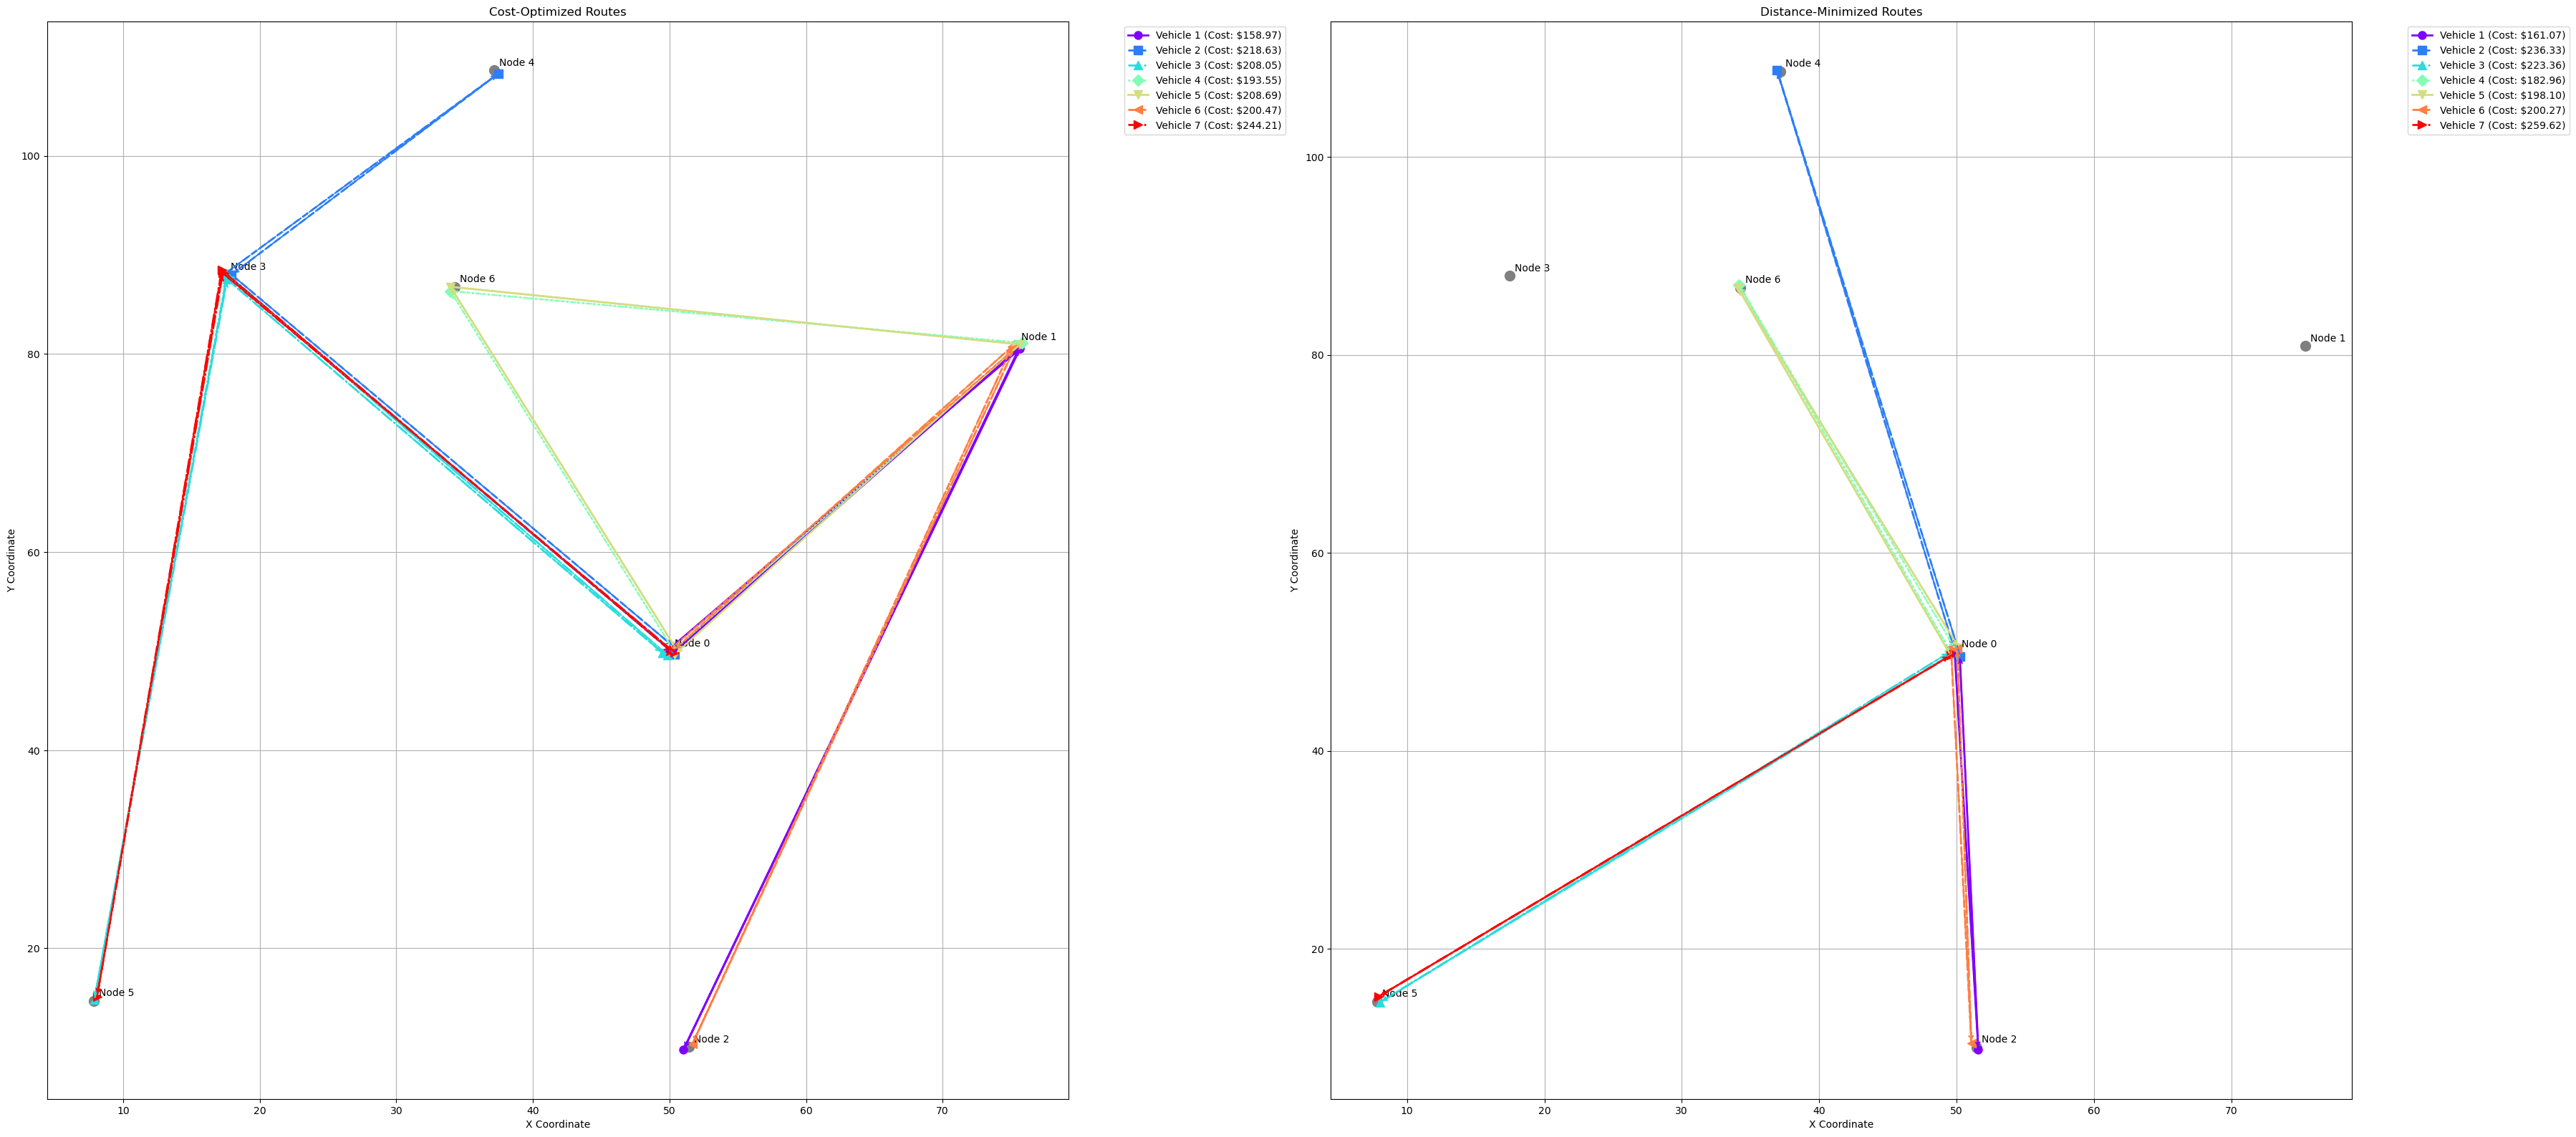

In [25]:
    # Display the cost-optimized and distance-minimized routes on X-Y axis with summary information
    #save_path = 'C:\Users\LENOVO\Desktop\Optimal Chargigng cycle\Model PIC'
    display_cost_and_distance_routes(nodes, routes_info, total_cost_optimized_distance, total_distance_minimized_distance, 
                                     total_cost_optimized_cost, total_distance_minimized_cost, total_operational_cost, 
                                     total_degradation_cost, total_delivery, total_pickup)